In [1]:
!nvidia-smi

Fri Jul 10 14:40:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Task #2

A template code for training an RBM on Rydberg atom data (the full dataset) is provided below. For the first part of this task (determining the minimum number of hidden units), start with 20 hidden units. 

### Imports and loading in data:

In [2]:
import numpy as np
import torch
from RBM_helper import RBM
import importlib
import Plotters
importlib.reload(Plotters)

import Rydberg_energy_calculator

training_data = torch.from_numpy(np.loadtxt("Rydberg_data.txt"))

### Helper for training the RBM

In [15]:
class RBMTrainer():
    def __init__(self, n_vis, n_hin, training_data):
        """
        RBMTrainer needs params to create an rbm and training data to work with
        """
        self.n_vis = n_vis
        self.n_hin = n_hin
        self.training_data = training_data
        
    def reset_state(self):
        self.rbm = RBM(self.n_vis, self.n_hin)
        self.best_epoch = None
        self.best_evaluation = None
        self.stopping_criterion_reached = False

    def run(self, epochs=1000, lr=1e-2, lr_annealing='',
            n_train_samples=20000, test_interval=50,
            n_test_samples=20000, stopping_patience=2, verbose=False,
            do_plot=False):
        """
        params:
            epochs - max number of epochs to train for
            lr - base learning rate
            lr_annealing - either 'lin' for linear annealing or 'geo' for
                            geometric annealing
            n_train_samples - number of samples to train with
            test_interval - how often (number of epochs) to stop and evaluate energy
            n_test_samples - how many samples to use for testings
                                more samples --> better statistical significance
            stopping_patience - how many times in a row the stopping criterion
                                    needs to be reached in order to stop early
                                    Set this to -1 to not stop early at all
            verbose - Whether to printout training progress indicators
            do_plot - Whether to have a live plot of the evaluated energy vs epochs
        Note: at the start of each run the state is reset
        """
        self.reset_state()
        
        n_train_samples = min(len(self.training_data), n_train_samples)

        exact_energy = -4.1203519096
        if verbose:
            print("Exact energy: ",exact_energy)

        # Stopping criterion
        # Difference between exact energy and simulated energy must be below this thresh
        diff_thresh = 1e-4

        if do_plot:
            plot_title = f"{self.n_hin} hidden neurons; training with {n_train_samples} samples; testing with {n_test_samples} samples"
            plotter = Plotters.XYPlotter(href=diff_thresh,
                                        title=plot_title,
                                        x_label="Epoch",
                                        y_label="Energy difference")
            %matplotlib inline

        patience_cnt = 0 # counter for stopping criterion
        for e in range(1, epochs+1):
            # do one epoch of training
            current_lr = lr
            if lr_annealing == 'lin':
                current_lr *= (1 - e / (epochs+1))
            elif lr_annealing == 'geo':
                ratio = (1e-4 / lr) ** (1/epochs)
                current_lr *= ratio ** e
            elif len(lr_annealing):
                raise UserWarning("lr_annealing must be one of '', 'lin', or 'geo'")
            self.rbm.train(self.training_data[:n_train_samples], lr=current_lr)   
        
            # now generate samples and calculate the energy
            if e % test_interval == 0:
                if verbose:
                    print("\nEpoch: ", e)
                    print("lr: ", current_lr)
                    print("Sampling...")

                init_state = torch.zeros(n_test_samples, self.n_vis)
                RBM_samples = self.rbm.draw_samples(100, init_state)

                if verbose:
                    print("Done sampling. Calculating energy...") 
        
                energies = Rydberg_energy_calculator.energy(RBM_samples, self.rbm.wavefunction) 
                if verbose:
                    print("Energy from RBM samples: ", energies.item())

                C = abs(energies.item() - exact_energy) # our "loss" function

                if do_plot:
                    plotter.update(e, C)

                # update metrics
                if self.best_evaluation is None or C < self.best_evaluation:
                    self.best_evaluation = C
                    self.best_epoch = e

                # stopping criterion
                if stopping_patience > 0 and C < diff_thresh:
                    patience_cnt += 1
                    if patience_cnt >= stopping_patience:
                        print(f'Algorithm stopped after {e} epochs with energy estimation {energies.item()}')
                        self.stopping_criterion_reached = True
                        break
                else:
                    patience_cnt = 0 # reset patience if we didn't hit the criterion
        
        if verbose:
            print(f'Training finalised. Best epoch: {self.best_epoch}; Best evaluation: {self.best_evaluation}')

### Do a standalone run

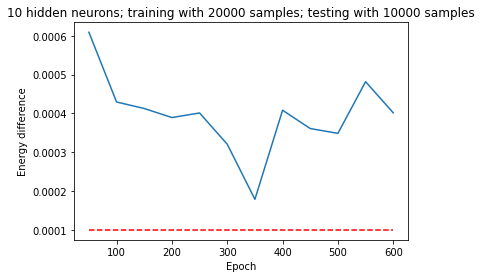

KeyboardInterrupt: ignored

In [14]:
trainer = RBMTrainer(training_data.shape[1], 10, training_data)
trainer.run(epochs=1000, lr=5e-2, do_lr_annealing=True, n_train_samples=20000,
            test_interval=50, n_test_samples=10000, stopping_patience=2,
            verbose=True, do_plot=True)

### Sweep over number of hidden nodes

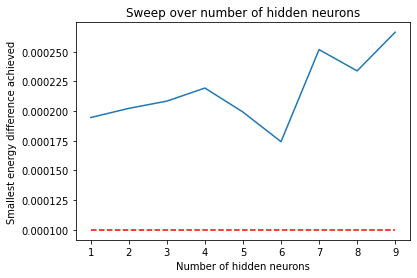

KeyboardInterrupt: ignored

In [ ]:
plot_title = "Sweep over number of hidden neurons"
plotter = Plotters.XYPlotter(href=diff_thresh,
                            title=plot_title,
                            x_label="Number of hidden neurons",
                            y_label="Smallest energy difference achieved")
%matplotlib inline

n_hin = 1
step = 1
while True:
    trainer = RBMTrainer(training_data.shape[1], n_hin, training_data)
    trainer.run(epochs=500, n_train_samples=20000, test_interval=50,
                n_test_samples=20000, stopping_patience=2, verbose=False,
                do_plot=False)
    plotter.update(n_hin, trainer.best_evaluation)
    if trainer.stopping_criterion_reached:
        print(f"Achieved stopping criterion with {n_hin} hidden neurons")
        break
    n_hin += step